# Machine Learning Foundation

## Section 2, Part c: Cross Validation 

## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
import pickle


In [3]:
boston = pickle.load(open("boston_housing_clean.pickle",mode="rb"))

In [6]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [9]:
df = boston['dataframe']
description = boston['description']

print(description)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [10]:
kf = KFold(shuffle=True, random_state=23456, n_splits=3 )

In [11]:
# splitting in x and Y
x = df.drop(columns=["MEDV"])
y = df["MEDV"]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [16]:
lr = LinearRegression()

In [23]:
scores = []
for train_idx, test_idx in kf.split(x):
    temp_train_feat = x.iloc[train_idx]
    temp_train_targ = y[train_idx]
    temp_test_feat  = x.iloc[test_idx]
    temp_test_targ  = y[test_idx]
    lr.fit(temp_train_feat,temp_train_targ)
    temp_score = r2_score(temp_test_targ, lr.predict(temp_test_feat))
    scores.append(temp_score)

print(scores)

[0.6315392061287662, 0.7556727904163659, 0.7130344151773451]


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

**Your response below**

#### Coding this up

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:

A bit cumbersome, but do-able.

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

**Your response below**

### Coding this up

In [ ]:
scores

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()
model = Pipeline([("scale", scaler),("regression", lr)])

In [29]:
predictions = cross_val_predict(model, x,y, cv=kf)
r2_score(y, predictions)

0.709355597323319

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [31]:
alpha = np.geomspace(1E-9, 1, 10)

In [33]:
scores = []
for a in alpha:
    las = Lasso(a)
    est = Pipeline([("scale",scaler),("regress",las)])
    predictions = cross_val_predict(est,x,y,cv=kf)
    scores.append(r2_score(y,predictions))
print(scores)

[0.7093555973625159, 0.7093555977137371, 0.7093556012543076, 0.7093556363286851, 0.7093559910357743, 0.7093594780985493, 0.7093942707111385, 0.7096691684984482, 0.7059294806227676, 0.6497524048292167]


### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [34]:
from sklearn.preprocessing import PolynomialFeatures

In [38]:
pol = PolynomialFeatures(degree=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for a in alphas:
    las = Lasso(a, max_iter=100000)
    est = Pipeline([("pol",pol),("scale",scaler),("regress",las)])
    predictions = cross_val_predict(est,x,y,cv=kf)
    scores.append(r2_score(y,predictions))
print(scores)

[0.8243791979141576, 0.8208890182039438, 0.8165139975565484, 0.8106795759483365, 0.8052684463213485, 0.7985329609276103, 0.7902070430889646, 0.7840762184090483, 0.7781060983455144, 0.7695807498503155, 0.7571273164061386, 0.7424811804193143, 0.7254114866956423, 0.7076424462723467, 0.6863516173813768, 0.6514446979166446, 0.5956123979745542, 0.5074947006831048, 0.3675786369581394, 0.1386769665159696]


If you store the results in a list called `scores`, the following will work:

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

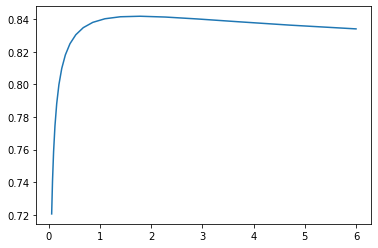

In [39]:
pol = PolynomialFeatures(degree=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for a in alphas:
    ridge = Ridge(a, max_iter=100000)
    est = Pipeline([("pol",pol),("scale",scaler),("regress",ridge)])
    predictions = cross_val_predict(est,x,y,cv=kf)
    scores.append(r2_score(y,predictions))
plt.plot(alphas, scores)

In [53]:
pol = PolynomialFeatures(degree=2)
ridge = Ridge(5,max_iter=100000)
est = Pipeline([("pol",pol),("scale",scaler),("regress",ridge)])

In [59]:
est.fit(x,y)
pd.DataFrame(zip(est.named_steps['pol'].get_feature_names(input_features=list(x.columns)), 
    est.named_steps['regress'].coef_))


,0,1
0,1,0.000000
1,CRIM,0.224158
2,ZN,-1.014847
3,INDUS,1.066566
4,CHAS,0.866939
...,...,...
100,PTRATIO B,0.199198
101,PTRATIO LSTAT,0.184028
102,B^2,-0.663494
103,B LSTAT,-1.393840


### Exercise:

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [ ]:
grid.fit(X, y)

In [ ]:
grid.best_score_, grid.best_params_

In [ ]:
y_predict = grid.predict(X)

In [ ]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

In [ ]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

In [ ]:
grid.cv_results_

## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation